# Imports

In [ ]:
# Basic Imports 
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Keras Imports 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# sklearn imports
from sklearn.metrics import classification_report, confusion_matrix


# 1. Data Loading and Preprocessing


In [ ]:
data_dir = 'images\images'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'test')

In [ ]:
# Image Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=20,
    zoom_range=0.2, 
    horizontal_flip=True
)
validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale'
)


validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale'
)

# 2. EDA (Visualizing Some Images)


In [ ]:
class_names = list(train_generator.class_indices.keys())

images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].reshape(48, 48), cmap='gray')
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.show()

# 3. CNN Model Architecture

In [ ]:
# 3. CNN Model Architecture
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(7, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# 4. Model Training


In [ ]:
# Callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# # Model Training
# history = model.fit(
#     train_generator,
#     epochs=5,
#     validation_data=validation_generator,
#     callbacks=[early_stopping, lr_scheduler]
# )

In [ ]:
# save the model 
model.save('emotion_model.h5')

# 6. Evaluation - Classification Report & Confusion Matrix

In [ ]:
# 6. Evaluation - Classification Report & Confusion Matrix
val_images, val_labels = next(validation_generator)
predictions = model.predict(val_images)
y_true = np.argmax(val_labels, axis=1)
y_pred = np.argmax(predictions, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 7. Detection System


1/1 [==============================] - 1s 911ms/step


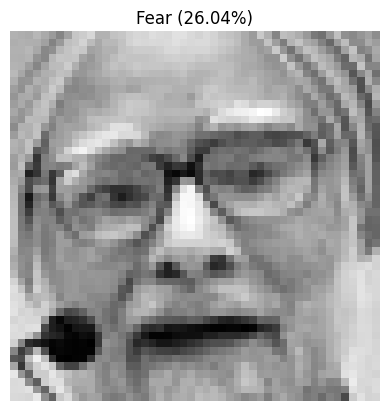

Emotion: Fear, Confidence: 26.04%


In [5]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Define class names
class_names = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# Load the trained model
model_path = 'emotion_model.h5'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Error: Model file '{model_path}' not found!")

model = load_model(model_path)

def detect_emotion(image_path):
    # Check if the image file exists
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Error: Image file '{image_path}' not found!")

    # Load the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError(f"Error: Unable to read the image at '{image_path}'. Check the file format!")

    # Resize the image to (48,48) to match model input
    img_resized = cv2.resize(img, (48, 48))

    # Normalize pixel values (0-255 → 0-1)
    img_array = img_resized / 255.0

    # Expand dimensions to match model input shape (batch_size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension

    # Predict emotion
    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_class = class_names[predicted_index]
    confidence = round(float(prediction[0][predicted_index]) * 100, 2)

    # Display the image with prediction (Using Matplotlib for better compatibility)
    plt.imshow(img_resized, cmap="gray")
    plt.title(f"{predicted_class} ({confidence}%)")
    plt.axis("off")
    plt.show()

    return predicted_class, confidence

# Example Detection
image_path = r'images\images\train\angry\1.jpg'  # Use raw string (r"...") for Windows paths
predicted_emotion, confidence = detect_emotion(image_path)
print(f"Emotion: {predicted_emotion}, Confidence: {confidence}%")
